In [1]:
import time

In [2]:
startTime = time.time()

In [3]:
%pip install nltk -U

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [5]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [6]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Add "eagerEval.enabled" to beautify the way Spark DF is displayed

In [7]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### Adjusting the driver size

In [8]:
import pyspark

In [9]:
sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Stop existing Spark environment
sc.stop()

# Waiting for the environment to stop
sleep_time = 20
print(f'Waiting for {sleep_time} seconds for the enviroment to stop...')
time.sleep(sleep_time)

# Applying new configuration and restarting Spark
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '32g')])
sc = pyspark.SparkContext(conf=conf)

print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Starting  Spark session with configs applied
spark = SparkSession(sc).builder.getOrCreate()

Original spark.driver.maxResultSize: 1920m
Waiting for 20 seconds for the enviroment to stop...


23/03/09 07:57:51 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/09 07:57:51 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/09 07:57:51 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/09 07:57:51 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


New spark.driver.maxResultSize: 32g


## Applying LSH

In [10]:
twitter_spark = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_categorize_twitteres//with_location1')
twitter_spark.count()

23/03/09 07:58:03 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


3141909

In [11]:
%%time

df = twitter_spark.filter("retweeted_status is null and tweet_text is not null and text is not null")
df.count()

CPU times: user 35.6 ms, sys: 15.5 ms, total: 51.1 ms
Wall time: 42.9 s


204841

In [12]:
df_tweet_text_raw = df.select(['tweet_text','Organization',"stripped"]).withColumnRenamed('stripped', 'text')

In [13]:
df_tweet_text_raw.limit(5).toPandas()

,tweet_text,Organization,text
0,today at alliance 🙂winners on learning games @ alliance university https://t.co/kujrirgu6o,Others,today at alliance 🙂winners on learning games alliance university
1,arkansas state students are asking the university to take action after racist posts on social media. https://t.co/nusfjpq5vr,Others,arkansas state students are asking the university to take action after racist posts on social media
2,davis college expands its international strategy via mou with infrastructure university of malaysia https://t.co/0seclsmnj7,News,davis college expands its international strategy via mou with infrastructure university of malaysia
3,"@thoughtstoby ah, i remember learning about that in secondary school. i doubt they mention it anymore",Others,thoughtstoby ah i remember learning about that in secondary school i doubt they mention it anymore
4,@gyaigyimii make the central university students go legon go watch the show\nuner deserves this spot,Others,gyaigyimii make the central university students go legon go watch the show\nuner deserves this spot


In [14]:
df_tweet_text_raw_sample = df_tweet_text_raw.sample(fraction = 0.1, withReplacement=False)
df_tweet_text_raw_sample.count()

20382

In [15]:
df_tweet_text_raw_sample.printSchema()

root
 |-- tweet_text: string (nullable = true)
 |-- Organization: string (nullable = true)
 |-- text: string (nullable = true)



### Step 1.  Clean the data, remove stopwords and create index

In [16]:
text = df_tweet_text_raw_sample.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .map( lambda word: [x for x in word if len(x) > 2] )\
    .zipWithIndex()

In [17]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [18]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{peshawar univers...,4747
{innocent element...,4748
{bonginoreport db...,4749
{college students...,4750
{i really believe...,4751


In [19]:
df_text.count()

20382

In [20]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[johnbruchalski, sure, university, received, doctorate, would, love, see]",0
1,"[said, michigan, graduate, proposes, college, sweetheart, commencement]",1
2,"[asonsiadek, played, college, graduation, celebration]",2
3,"[still, flabbergasted, college, students, refuse, focus, major, chase, minors, around]",3
4,"[gametimerc, carroll, university, offers, marquette, university]",4


In [21]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [22]:
df_tokens.count()

20380

### Step 2. Fit countvectorizer to create word features

In [23]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [24]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[johnbruchalski, sure, university, received, doctorate, would, love, see]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[said, michigan, graduate, proposes, college, sweetheart, commencement]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[asonsiadek, played, college, graduation, celebration]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[still, flabbergasted, college, students, refuse, focus, major, chase, minors, around]",3,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[gametimerc, carroll, university, offers, marquette, university]",4,"(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


### Step 3. Fit MinHashLSH to create hash table

**Note:** Adding more hash tables will increase the accuracy at the expense of training time

In [25]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [26]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
26,{maryville univer...,"[maryville, unive...","(26655,[1,2,67,71...","[[3.89054535E8], ..."
29,{good question se...,"[good, question, ...","(26655,[0,2,30,41...","[[2.5247665E7], [..."
474,{homework slave f...,"[homework, slave,...","(26655,[1,46,169,...","[[3.72403104E8], ..."
964,{i’m obsessed wit...,"[obsessed, kotaro...","(26655,[0,7,2420,...","[[4.7945584E7], [..."
1677,{ksorbs comparing...,"[ksorbs, comparin...","(26655,[0,4,141,3...","[[6570254.0], [1...."


### Step 4. Establish similarity threshold and return near-duplicate records
**Note:** we are joining dataframe to itself to get near-duplicate pairs

#### Low jaccard distance

In [27]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [28]:
df_dups_30 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.00,429,3215,"(college graduation is so long!,)","(college graduation today✨ ,)"
1,0.00,1709,3449,"(the importance of schools in conducting benchmark testing education learning,)","(the importance of schools in conducting benchmark testing education learning,)"
2,0.00,5776,16598,"(no more college students 😭,)","(college students,)"
3,0.25,189,3946,"(this or have free university education 🥰,)","(mollyjake3 free university education,)"
4,0.00,3008,18830,"(need money for college\nneed college for job\nneed job for money-_-\nwhat who the hell designed this system??,)","(need money for college\nneed college for job\nneed job for money-_-\nwhat who the hell designed this system??,)"


In [29]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  20382
Duplicate titles based on { 0.3 } jaccard distance:  1460
Unique titles based on { 0.3 } jaccard distance:  0.3 :  18922


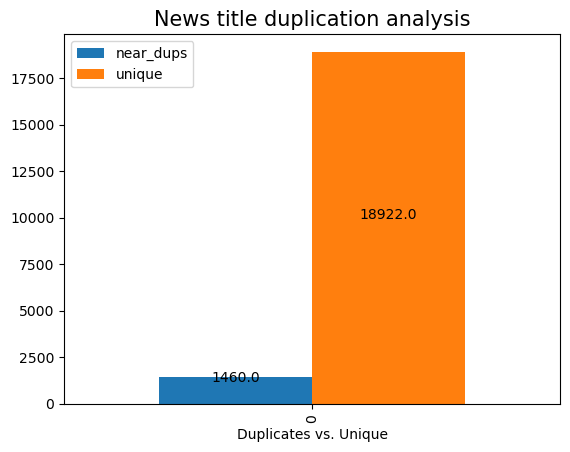

In [30]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [31]:
df_dups_1 = df_dups_text.select(col('id_A').alias('id')).distinct().withColumn('is_dups',lit('near_dups'))

df_final = df_tweet_text_raw.select('Organization').rdd.zipWithIndex().toDF(['org','id'])\
.join(df_dups_1,'id','left')\
.na.fill(value='unique',subset=['is_dups'])\
.select('id',col('org.Organization').alias('org'),'is_dups')

df_final.show(10)

+---+-------+---------+
| id|    org|  is_dups|
+---+-------+---------+
|  0| Others|   unique|
|  1| Others|   unique|
|  2|   News|   unique|
|  3| Others|   unique|
|  4| Others|   unique|
|  5| Others|   unique|
|  6| Others|   unique|
|  7|    NGO|   unique|
|  8| Others|near_dups|
|  9|Schools|   unique|
+---+-------+---------+
only showing top 10 rows



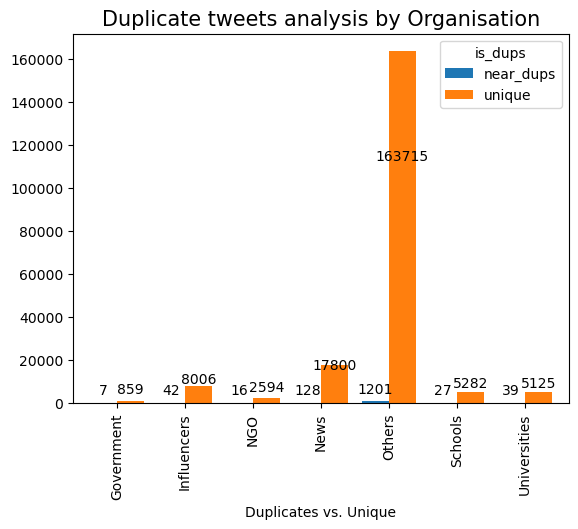

In [36]:
df_plt = df_final.groupBy('org','is_dups').agg(count('*').alias('cnt')).toPandas()

ax=df_plt.pivot(index='org', columns='is_dups', values='cnt').plot(kind='bar', fontsize=10, color=['C0', 'C1'],
                                                                align='center', width=0.8, 
                                                                xlabel="Duplicates vs. Unique")

ax.set_title('Duplicate tweets analysis by Organisation', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/ 1.5), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

**With Jaccard Distance 0.4**

In [38]:
jaccard_distance = 0.4

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [39]:
df_dups_40 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.333333,11743,13949,"(she’s literally a college graduate,)","(a college graduate i am 😭🥺❤️,)"
1,0.000000,2527,13783,"(i see life like one long university education i never had i learn something every day – richard branson leadership success,)","(i see life like one long university education i never had i learn something every day – richard branson leadership success,)"
2,0.333333,761,1942,"(im college students 😭,)","(gifts for college students – 45 gifts college students will actually appreciate ,)"
3,0.333333,3994,10554,"(the what guy is college graduate,)","(i’ll be a college graduate in a week!!,)"
4,0.333333,3367,10166,"(thanks tom! im a middle school teacher not an economist!,)","(xiggy89x thanks im a middle school special ed teacher \n,)"


In [40]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  20382
Duplicate titles based on { 0.4 } jaccard distance:  1839
Unique titles based on { 0.4 } jaccard distance:  0.4 :  18543


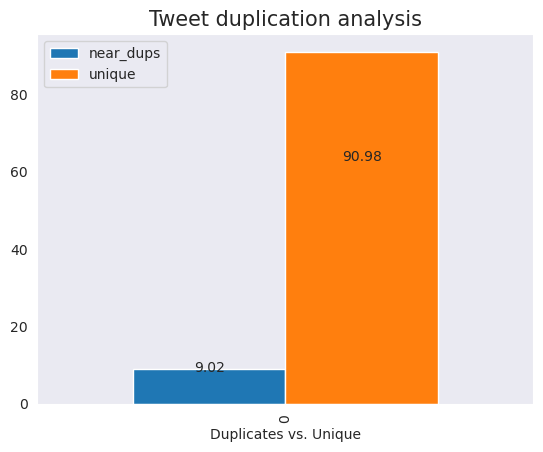

In [170]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweet duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/1.5), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [169]:
dups = (1839/20382)*100
uniques = (18543/20382)*100

In [42]:
df_dups_1 = df_dups_text.select(col('id_A').alias('id')).distinct().withColumn('is_dups',lit('near_dups'))

df_final = df_tweet_text_raw.select('Organization').rdd.zipWithIndex().toDF(['org','id'])\
.join(df_dups_1,'id','left')\
.na.fill(value='unique',subset=['is_dups'])\
.select('id',col('org.Organization').alias('org'),'is_dups')

df_final.show(10)

+---+-------+---------+
| id|    org|  is_dups|
+---+-------+---------+
|  0| Others|   unique|
|  1| Others|   unique|
|  2|   News|   unique|
|  3| Others|   unique|
|  4| Others|   unique|
|  5| Others|   unique|
|  6| Others|   unique|
|  7|    NGO|   unique|
|  8| Others|near_dups|
|  9|Schools|   unique|
+---+-------+---------+
only showing top 10 rows



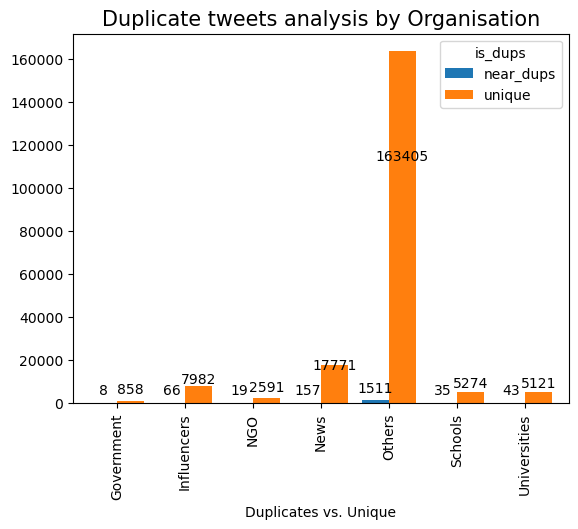

In [43]:
df_plt = df_final.groupBy('org','is_dups').agg(count('*').alias('cnt')).toPandas()

ax=df_plt.pivot(index='org', columns='is_dups', values='cnt').plot(kind='bar', fontsize=10, color=['C0', 'C1'],
                                                                align='center', width=0.8, 
                                                                xlabel="Duplicates vs. Unique")

ax.set_title('Duplicate tweets analysis by Organisation', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/1.5), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Medium jaccard distance

In [44]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [45]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.400000,5213,19732,"(malachi2224521 what if you’re not in elementary school but middle school,)","(jamal_hambone wakecountymugs not elementary and middle school 😂😂💀💀,)"
1,0.400000,9222,12133,"(_bloomsqueen im a daycare teacher at an elementary school,)","(not me being a whole elementary school teacher 🍎📓,)"
2,0.333333,11743,13949,"(she’s literally a college graduate,)","(a college graduate i am 😭🥺❤️,)"
3,0.454545,17734,19493,"(winchester college guided tours winchester college winchester on tue 6 dec 2022 1130am guidedtour tickets: ,)","(winchester college guided tours winchester college winchester on sat 29 oct 2022 guidedtour tickets: ,)"
4,0.461538,2307,4316,"(the latest the eethg corps inc university college daily! thanks to maviarri23 education bigdata,)","(the latest the eethg corps inc university college daily! thanks to shanesbaker77 covid19 marxist,)"


In [46]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  20382
Duplicate titles based on { 0.5 } jaccard distance:  2262
Unique titles based on { 0.5 } jaccard distance:  0.5 :  18120


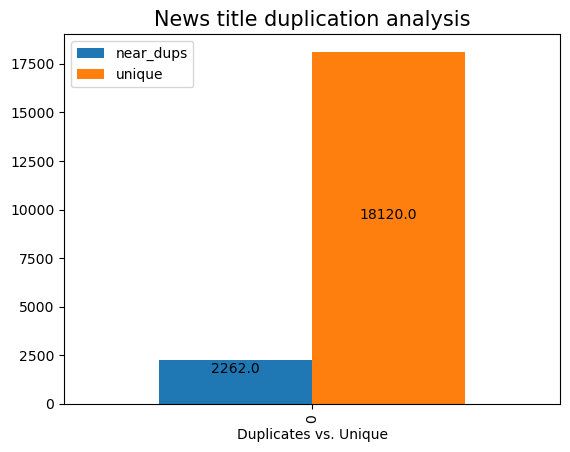

In [47]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [48]:
df_dups_1 = df_dups_text.select(col('id_A').alias('id')).distinct().withColumn('is_dups',lit('near_dups'))

df_final = df_tweet_text_raw.select('Organization').rdd.zipWithIndex().toDF(['org','id'])\
.join(df_dups_1,'id','left')\
.na.fill(value='unique',subset=['is_dups'])\
.select('id',col('org.Organization').alias('org'),'is_dups')

df_final.show(10)

+---+-------+---------+
| id|    org|  is_dups|
+---+-------+---------+
|  0| Others|   unique|
|  1| Others|   unique|
|  2|   News|   unique|
|  3| Others|   unique|
|  4| Others|   unique|
|  5| Others|   unique|
|  6| Others|   unique|
|  7|    NGO|   unique|
|  8| Others|near_dups|
|  9|Schools|   unique|
+---+-------+---------+
only showing top 10 rows



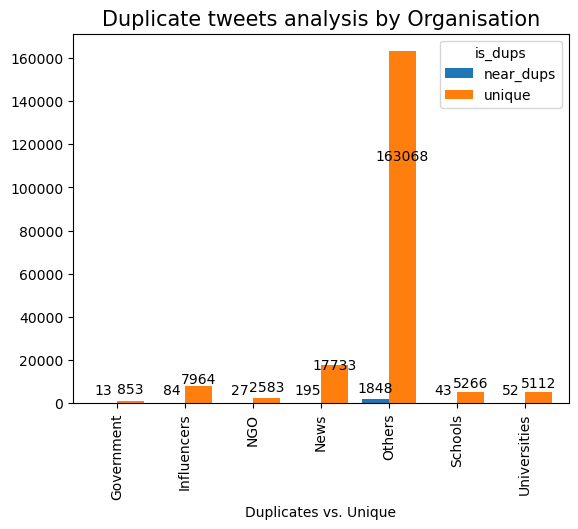

In [49]:
df_plt = df_final.groupBy('org','is_dups').agg(count('*').alias('cnt')).toPandas()

ax=df_plt.pivot(index='org', columns='is_dups', values='cnt').plot(kind='bar', fontsize=10, color=['C0', 'C1'],
                                                                align='center', width=0.8, 
                                                                xlabel="Duplicates vs. Unique")

ax.set_title('Duplicate tweets analysis by Organisation', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/1.5), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### High jaccard distance

In [50]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [51]:
df_dups_70 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.666667,8440,17983,"(elementary and middle school reunion,)","(veningstar4 yeah i used to watch him so much when i was in elementary and middle school,)"
1,0.666667,8440,14877,"(elementary and middle school reunion,)","(maternal grandmother: seamstress\npaternal grandmother: elementary school teacher,)"
2,0.400000,8440,18221,"(elementary and middle school reunion,)","(middle school elementary as well,)"
3,0.363636,16742,17233,"(winchester college guided tours winchester college winchester on thu 1 sep 2022 215pm guidedtour tickets: ,)","(winchester college guided tours winchester college winchester on sun 18 dec 2022 215pm guidedtour tickets: ,)"
4,0.000000,17499,18939,"(ayah_creatives hello! first year college student here! also a stem grad po! dm me po!,)","(_fan_acc_ hello! first year college student here! also a stem grad po! dm me po!,)"


In [52]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  20382
Duplicate titles based on { 0.7 } jaccard distance:  8819
Unique titles based on { 0.7 } jaccard distance:  0.7 :  11563


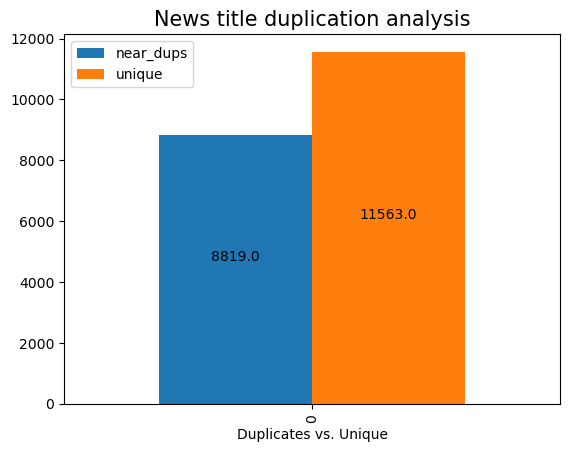

In [53]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [54]:
df_dups_1 = df_dups_text.select(col('id_A').alias('id')).distinct().withColumn('is_dups',lit('near_dups'))

df_final = df_tweet_text_raw.select('Organization').rdd.zipWithIndex().toDF(['org','id'])\
.join(df_dups_1,'id','left')\
.na.fill(value='unique',subset=['is_dups'])\
.select('id',col('org.Organization').alias('org'),'is_dups')

df_final.show(10)

+---+-------+---------+
| id|    org|  is_dups|
+---+-------+---------+
|  0| Others|near_dups|
|  1| Others|near_dups|
|  2|   News|near_dups|
|  3| Others|   unique|
|  4| Others|   unique|
|  5| Others|   unique|
|  6| Others|   unique|
|  7|    NGO|   unique|
|  8| Others|near_dups|
|  9|Schools|   unique|
+---+-------+---------+
only showing top 10 rows



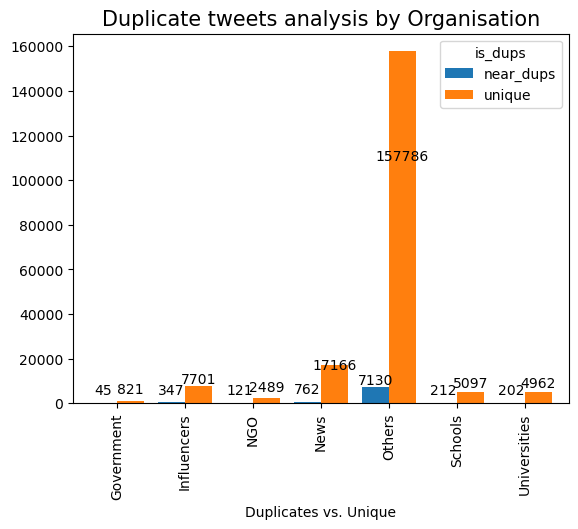

In [55]:
df_plt = df_final.groupBy('org','is_dups').agg(count('*').alias('cnt')).toPandas()

ax=df_plt.pivot(index='org', columns='is_dups', values='cnt').plot(kind='bar', fontsize=10, color=['C0', 'C1'],
                                                                align='center', width=0.8, 
                                                                xlabel="Duplicates vs. Unique")

ax.set_title('Duplicate tweets analysis by Organisation', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/1.5), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [56]:
spark.catalog.clearCache()

### Step 5. Compare thresholds side-by-side

#### Select all pairs of duplicate titles across jaccard similarities

In [ ]:
df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_40_id = df_dups_40.select(col('id_A').alias('id_40_A'), col('id_B').alias('id_40_B'))
df_dups_70_id = df_dups_70.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_40_id.count())
print(df_dups_70_id.count())

4962


9689


187716


In [ ]:
dups_combined = df_dups_70_id.join(df_dups_40_id, on=((df_dups_70_id.id_70_A == df_dups_40_id.id_40_A) & (df_dups_70_id.id_70_B == df_dups_40_id.id_40_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

dups_combined.limit(5)

text_A,text_B,id_70_A,id_70_B,id_40_A,id_40_B,id_30_A,id_30_B
{i see life like ...,{i see life like ...,2527,13783,2527,13783,2527,13783
{uprooted academy...,{lunch and learn!...,10416,14612,null,null,null,null
{andrew kimondo: ...,{tales of a bipol...,3897,17645,3897,17645,3897,17645
{the importance o...,{the importance o...,1709,3449,1709,3449,1709,3449
{college life or ...,{freshman college...,3939,16164,null,null,null,null


#### Create a Duplicate vs Non-Dup flag for each jaccard similarity

In [ ]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_40",\
           when(col("id_40_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_40_A', 'id_40_B', 'id_70_A', 'id_70_B')

dups_combined.limit(5)

text_A,text_B,threshold_30,threshold_40,threshold_70
{thelondon_lewk a...,{captain toad: te...,Non-Dup,Non-Dup,Duplicate
{middle school te...,{agcoffeelmao he ...,Non-Dup,Non-Dup,Duplicate
{its so heartwarm...,{4 steps to get m...,Non-Dup,Non-Dup,Duplicate
{fiddlesticks ste...,{lmao not me seei...,Non-Dup,Non-Dup,Duplicate
{so sure miserabl...,{🇺🇸 : depressio...,Non-Dup,Non-Dup,Duplicate


#### Select a sample of records across 3 thresholds (jaccard similarities):

In [ ]:
dups_combined_sample = \
dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
union\
(dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_40 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
union\
(dups_combined.filter(("threshold_40 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
orderBy('threshold_30', 'threshold_40', 'threshold_70')

In [ ]:
pd.set_option('display.max_rows', 30)
dups_combined_sample.toPandas()

,text_A,text_B,threshold_30,threshold_40,threshold_70
0,"(in addition to higher education you need to have at least a high school mind and at least an elementary education,)","(in addition to higher education you need to have at least a high school mind and at least an elementary education,)",Duplicate,Duplicate,Duplicate
1,"(ohio university pays 400000 in damages to professor who refused to use students preferred pronouns ,)","(ohio university pays 400000 in damages to professor who refused to use students preferred pronouns ,)",Duplicate,Duplicate,Duplicate
2,"(now playing californians for all college corps (15sec) - californians for all college corps (15sec),)","(now playing californians for all college corps (15sec) - californians for all college corps (15sec),)",Duplicate,Duplicate,Duplicate
3,"(i see life like one long university education i never had i learn something every day – richard branson leadership success,)","(i see life like one long university education i never had i learn something every day – richard branson leadership success,)",Duplicate,Duplicate,Duplicate
4,"(the importance of schools in conducting benchmark testing education learning,)","(the importance of schools in conducting benchmark testing education learning,)",Duplicate,Duplicate,Duplicate
5,"(now playing californians for all college corps (15sec) - californians for all college corps (15sec),)","(now playing californians for all college corps (30sec) - californians for all college corps (30sec),)",Duplicate,Duplicate,Duplicate
6,"(now playing californians for all college corps (30sec) - californians for all college corps (30sec),)","(now playing californians for all college corps (15sec) - californians for all college corps (15sec),)",Duplicate,Duplicate,Duplicate
7,"(taliban bans university education for afghan girls ,)","(taliban bans university education for afghan girls culture ,)",Duplicate,Duplicate,Duplicate
8,"(n76247476man elementary school teacher,)","(keepstrugglin_ elementary school teacher,)",Duplicate,Duplicate,Duplicate
9,"(onslow county school teacher charged with secretly recording undressed students ,)","(onslow county school teacher charged with secretly recording undressed students ,)",Duplicate,Duplicate,Duplicate


**For 0.7 jaccard similarity event if the texts are not relevant they are being said as duplicate. I would be choosing 0.4 as my Jaccard similarity**

## Similarity analysis for individual organizations i.e., University, School, Government ...

In [ ]:
pd_df_tweet_text_raw = df_tweet_text_raw.groupBy('Organization').agg(count('text').alias('count_of_tweets')).toPandas()

In [ ]:
pd_df_tweet_text_raw

,Organization,count_of_tweets
0,Government,866
1,NGO,2610
2,Influencers,8048
3,Others,164916
4,Schools,5309
5,Universities,5164
6,News,17928


In [ ]:
def get_tokens(df):
    return df\
        .map( lambda document: re.split(" ", document))\
        .map( lambda word: [x for x in word if len(x) >= 2] )\
        .map( lambda word: [x for x in word if x not in StopWords])\
        .zipWithIndex()

In [ ]:
def to_DF(rdd_, col):    
    row = Row(col)
    return rdd_.map(row).zipWithIndex().toDF([col, 'id'])

In [ ]:
def token_cleaning(tokens):
    df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
    df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
    return df_tokens

In [ ]:
mh = MinHashLSH(inputCol = "features", outputCol = "hashes", numHashTables = 5)
def get_df_hashed(df_vectorize):
    model = mh.fit(df_vectorize)
    df_hashed = mh.fit(df_vectorize).transform(df_vectorize)
    return model, df_hashed

In [ ]:
def getJaccardBarChart(df, jaccard_distance, model):

    df_dups_text = model.approxSimilarityJoin(
                        df, df, jaccard_distance
                    ).filter("datasetA.id < datasetB.id").select(
                        col("distCol"),
                        col("datasetA.id").alias("id_A"),
                        col("datasetB.id").alias("id_B"),
                        col("datasetA.text").alias('text_A'),
                        col("datasetB.text").alias('text_B')
                    )

    df_dups_text.cache()
    df_dups_text.limit(5).toPandas()
    
    records = df.count()
    dups = df_dups_text.select('id_A').distinct().count()
    uniques = records - dups
    
#     clear_output(wait = True)
    
    return df_dups_text, records, dups

In [ ]:
StopWords = stopwords.words("english")

def run_similarity(Organization, fraction_filter):
    if(fraction_filter == 1):
        part_to_analyse = df_tweet_text_raw.filter("Organization == '" + Organization + "'")
    else:
        part_to_analyse = df_tweet_text_raw.filter("Organization == '" + Organization + "'")
        part_to_analyse = part_to_analyse.sample(withReplacement = False, fraction = fraction_filter, seed = 42)
    
    
    part_to_analyse = part_to_analyse.cache()
    tweets = part_to_analyse.rdd.map(lambda x : x['text'])

    global StopWords
    text_tokens = get_tokens(tweets)

    df_tweets = to_DF(tweets, 'text')
    df_tweets_tokens = token_cleaning(text_tokens)

    vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
    df_tweets_tokens_vectorized = vectorize.fit(df_tweets_tokens).transform(df_tweets_tokens)

    model, df_hashed= get_df_hashed(df_tweets_tokens_vectorized)

    df_hashed_text_joined = df_tweets.join(df_hashed, "id", how = 'left')

    df_hashed_text_joined = df_hashed_text_joined.\
                                where(size(df_hashed_text_joined.list_of_words) >= 5)

    text_dups_list = []
    df_dups_text_20, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.2, model)
    df_dups_text_20
    text_dups_list.append([Organization, records, dups, records - dups, 0.2])

    df_dups_text_30, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.3, model)
    text_dups_list.append([Organization, records, dups, records - dups, 0.3])

    df_dups_text_40, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.4, model)
    text_dups_list.append([Organization, records, dups, records - dups, 0.4])

    df_dups_text_60, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.5, model)
    text_dups_list.append([Organization, records, dups, records - dups, 0.5])

    df_dups_text_70, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.7, model)
    text_dups_list.append([Organization, records, dups, records - dups, 0.7])
    
    df_dups_20_id = df_dups_text_20.select(col('id_A').alias('id_20_A'), col('id_B').alias('id_20_B'))
    df_dups_30_id = df_dups_text_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
    df_dups_40_id = df_dups_text_40.select(col('id_A').alias('id_40_A'), col('id_B').alias('id_40_B'))
    df_dups_70_id = df_dups_text_70.select(col('text_A'), col('text_B'),\
                                      col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))
    
    dups_combined = df_dups_70_id.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")\
    .join(df_dups_20_id, on=((df_dups_70_id.id_70_A == df_dups_20_id.id_20_A) & (df_dups_70_id.id_70_B == df_dups_20_id.id_20_B)), how="left_outer")

    dups_combined = dups_combined.\
    withColumn("threshold_20",\
               when(col("id_20_A").isNotNull(), "Duplicate").
               otherwise("Non-Dup")).\
    withColumn("threshold_30",\
               when(col("id_30_A").isNotNull(), "Duplicate").
               otherwise("Non-Dup")).\
    withColumn("threshold_70",\
               when(col("id_70_A").isNotNull(), "Duplicate").
               otherwise("Non-Dup")).\
    drop('id_20_A', 'id_20_B', 'id_30_A', 'id_30_B', 'id_70_A', 'id_70_B')

    dups_combined_sample = \
    dups_combined.filter(("threshold_20 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
    union\
    (dups_combined.filter(("threshold_20 == 'Non-Dup' and threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
    union\
    (dups_combined.filter(("threshold_30 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
    orderBy('threshold_20', 'threshold_30', 'threshold_70')
    
    pd_similarity_check_tweets = dups_combined_sample.toPandas()

#     df_ = pd.DataFrame(text_dups_list, columns = ['counts', 'dups', 'unique', 'threshold'])
#     df_.plot(x = 'threshold', y = ['unique','dups'], kind = 'bar', title = i)
#     plt.show()
    return text_dups_list, pd_similarity_check_tweets

In [ ]:
gov_text_dups_list, pd_gov_similiraity_check_tweets = run_similarity('Government', 1)

In [ ]:
spark.catalog.clearCache()

In [ ]:
ngo_text_dups_list, pd_ngo_similiraity_check_tweets = run_similarity('NGO', 1)

In [ ]:
spark.catalog.clearCache()

In [ ]:
influ_text_dups_list, pd_influ_similiraity_check_tweets = run_similarity('Influencers', 1)

In [ ]:
spark.catalog.clearCache()

In [ ]:
others_text_dups_list, pd_others_similiraity_check_tweets = run_similarity('Others', 0.1)

In [ ]:
spark.catalog.clearCache()

In [ ]:
schools_text_dups_list, pd_schools_similiraity_check_tweets = run_similarity('Schools', 1)

In [ ]:
spark.catalog.clearCache()

In [ ]:
uni_text_dups_list, pd_uni_similiraity_check_tweets = run_similarity('Universities', 1)

In [ ]:
spark.catalog.clearCache()

In [ ]:
news_text_dups_list, pd_news_similiraity_check_tweets = run_similarity('News', 1)

In [ ]:
spark.catalog.clearCache()

In [88]:
pd_gov_text_dups = pd.DataFrame(gov_text_dups_list, columns = ['org','counts', 'dups', 'unique', 'threshold'])
pd_ngo_text_dups = pd.DataFrame(ngo_text_dups_list, columns = ['org','counts', 'dups', 'unique', 'threshold'])
pd_influ_text_dups = pd.DataFrame(influ_text_dups_list, columns = ['org','counts', 'dups', 'unique', 'threshold'])
pd_others_text_dups = pd.DataFrame(others_text_dups_list, columns = ['org','counts', 'dups', 'unique', 'threshold'])
pd_schools_text_dups_list = pd.DataFrame(schools_text_dups_list, columns = ['org','counts', 'dups', 'unique', 'threshold'])
pd_uni_text_dups_list = pd.DataFrame(uni_text_dups_list, columns = ['org','counts', 'dups', 'unique', 'threshold'])
pd_news_text_dups_list = pd.DataFrame(news_text_dups_list, columns = ['org','counts', 'dups', 'unique', 'threshold'])


df_plt = pd.concat([pd_gov_text_dups, pd_ngo_text_dups, pd_influ_text_dups, pd_others_text_dups, pd_schools_text_dups_list, 
                   pd_uni_text_dups_list, pd_news_text_dups_list])

df_plt.head(10)

,org,counts,dups,unique,threshold
0,Government,854,27,827,0.2
1,Government,854,32,822,0.3
2,Government,854,53,801,0.4
3,Government,854,61,793,0.5
4,Government,854,89,765,0.7
0,NGO,2554,235,2319,0.2
1,NGO,2554,245,2309,0.3
2,NGO,2554,258,2296,0.4
3,NGO,2554,271,2283,0.5
4,NGO,2554,439,2115,0.7


In [153]:
df_plt1 = df_plt

df_plt1['perc_dups'] = df_plt1['dups']/df_plt1['counts']
df_plt1['perc_uni'] = 1 - df_plt1['perc_dups']

df_plt2 = df_plt1[['org','perc_dups','threshold']]

df_plt3 = df_plt2.pivot(index='org',columns='threshold',values='perc_dups')

df_plt3.head()

threshold,0.2,0.3,0.4,0.5,0.7
org,,,,,
Government,0.031616,0.037471,0.062061,0.071429,0.104215
Influencers,0.068935,0.078143,0.088247,0.099501,0.208467
NGO,0.092013,0.095928,0.101018,0.106108,0.171887
News,0.135414,0.154324,0.178539,0.203883,0.377117
Others,0.041117,0.050136,0.059343,0.069055,0.217191


In [154]:
df_plt3[0.4] = (df_plt3[0.4]*100).round(2)

In [155]:
df_plt3.columns

Float64Index([0.2, 0.3, 0.4, 0.5, 0.7], dtype='float64', name='threshold')

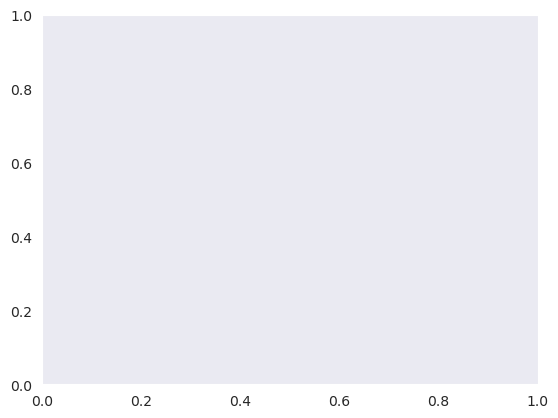

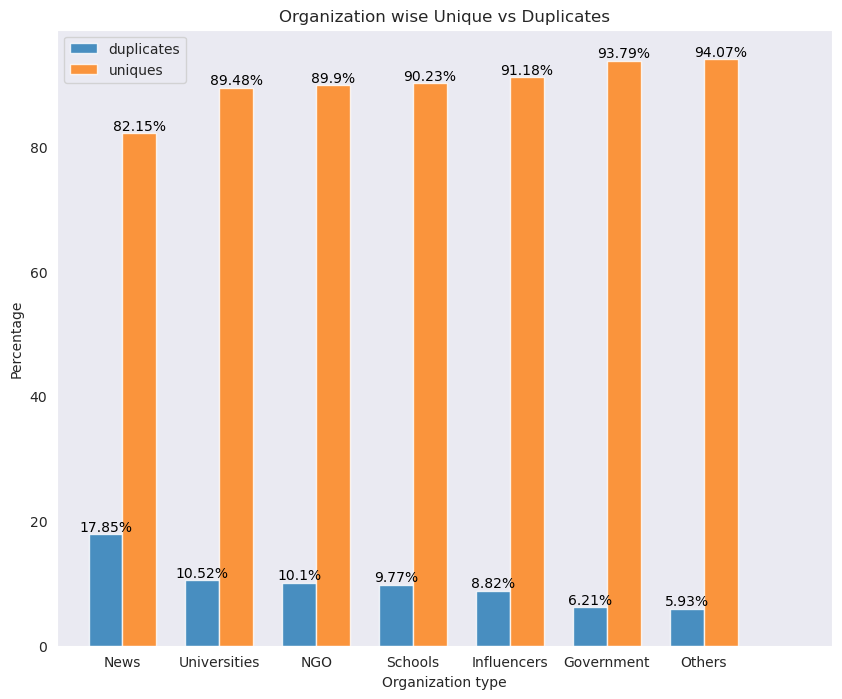

In [161]:
data_04 = df_plt3[0.4].sort_values(ascending=False)

# plot the data
fig, ax = plt.subplots()
bar_width = 0.5
opacity = 0.8
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

data_06 = 100 - data_04

# Plot parameters
bar_width = 0.35
opacity = 0.8
colors = ['#1f77b4', '#ff7f0e']

# Plot bars
fig, ax = plt.subplots(figsize = (10, 8))
x = np.arange(len(data_04))
rects1 = ax.bar(x, data_04, bar_width, alpha=opacity, color=colors[0], label='duplicates')
rects2 = ax.bar(x + bar_width, data_06, bar_width, alpha=opacity, color=colors[1], label='uniques')

# Add labels, title, and legend
ax.set_xlabel('Organization type')
ax.set_ylabel('Percentage')
ax.set_title('Organization wise Unique vs Duplicates')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(list(data_04.index))

ax.set_xlim([x[0] - 0.5, x[-1] + 1.5])

# Add text labels to the bars
for i, rect in enumerate(rects1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., height, str(data_04[i]) + '%', ha='center', va='bottom', color='black')

for i, rect in enumerate(rects2):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., height, str(data_06[i]) + '%', ha='center', va='bottom', color='black')

# Add legend
ax.legend()

# Show the plot
plt.show()

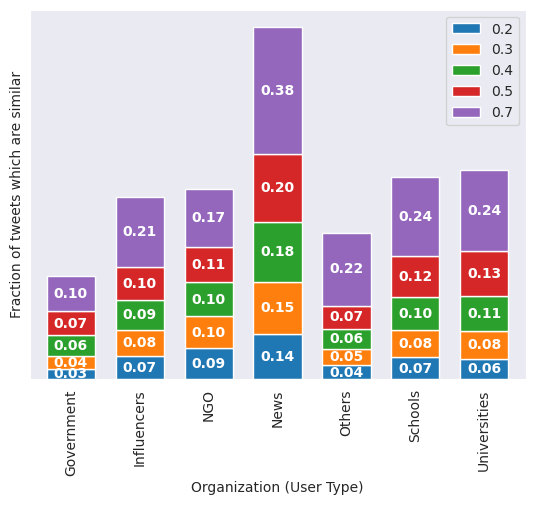

In [109]:
import seaborn as sns
sns.set_style("dark")
plt.figure.figsize = (100, 50)
fig = df_plt3.plot.bar(width = 0.7, stacked = True)
fig.set_ylabel('Fraction of tweets which are similar')
fig.set_xlabel('Organization (User Type)')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.tick_params( axis='y', which='both', left = False, 
                 labelleft = False, labelbottom = False
               )
for x in fig.containers:
    fig.bar_label(x, label_type='center', fmt = '%1.2f', weight = 'bold', color='white')
plt.show()

In [121]:
pd_news_similiraity_check_tweets

,text_A,text_B,threshold_20,threshold_30,threshold_70
0,"(tiwa savage set to receive doctorate honours from kent university ,)","(tiwa savage set to receive doctorate honours from kent university ,)",Duplicate,Duplicate,Duplicate
1,"(read adjunctnation today: hybrid learning and cheating: assessment must evolve adjuncts highered college,)","(read adjunctnation today: hybrid learning and cheating: assessment must evolve adjuncts highered college,)",Duplicate,Duplicate,Duplicate
2,"(education without god ▸\n\neducation children college,)","(education without god ▸\n\neducation children college,)",Duplicate,Duplicate,Duplicate
3,"(authorities say theyve received thousands of tips regarding 4 slain university of idaho students ,)","(authorities say theyve received thousands of tips regarding 4 slain university of idaho students ,)",Duplicate,Duplicate,Duplicate
4,"(hubert davis brings out north carolina’s toughness at the garden\n\nohio university university university ,)","(hubert davis brings out north carolina’s toughness at the garden\n\nohio university university university ,)",Duplicate,Duplicate,Duplicate
5,"(english medium schools are offering quality of education to students opening\ntheir doors for right opportunities 4saalbadhtarajasthan,)","(english medium schools are offering quality of education to students opening\ntheir doors for right opportunities 4saalbadhtarajasthan,)",Duplicate,Duplicate,Duplicate
6,"(california is on track to remove any reason for its public university students to take out student loans ,)","(california is on track to remove any reason for its public university students to take out student loans ,)",Duplicate,Duplicate,Duplicate
7,"(read adjunctnation today: college students are increasingly identifying beyond “she” and “he” adjuncts highered,)","(read adjunctnation today: college students are increasingly identifying beyond “she” and “he” adjuncts highered,)",Duplicate,Duplicate,Duplicate
8,"(hubert davis brings out north carolina’s toughness at the garden\n\nohio university university university ,)","(hubert davis brings out north carolina’s toughness at the garden\n\nohio university university university ,)",Duplicate,Duplicate,Duplicate
9,"(authorities say theyve received thousands of tips regarding 4 slain university of idaho students ,)","(authorities say theyve received thousands of tips regarding 4 slain university of idaho students ,)",Duplicate,Duplicate,Duplicate


In [89]:
df_plt.to_csv('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_similarity_values_plt/data.csv')

In [90]:
df = pd.read_csv('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_similarity_values_plt/data.csv')

In [93]:
pd_gov_similiraity_check_tweets.to_csv('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_similarity_check_texts/governemnt.csv')

In [94]:
pd_ngo_similiraity_check_tweets.to_csv('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_similarity_check_texts/ngo.csv')

In [95]:
pd_influ_similiraity_check_tweets.to_csv('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_similarity_check_texts/influencers.csv')

In [114]:
pd_others_similiraity_check_tweets.to_csv('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_similarity_check_texts/others.csv')

In [115]:
pd_schools_similiraity_check_tweets.to_csv('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_similarity_check_texts/schools.csv')

In [116]:
pd_uni_similiraity_check_tweets.to_csv('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_similarity_check_texts/universities.csv')

In [117]:
pd_news_similiraity_check_tweets.to_csv('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_similarity_check_texts/news.csv')

In [101]:
pd.read_csv('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_similarity_check_texts/governemnt.csv')

,Unnamed: 0,text_A,text_B,threshold_20,threshold_30,threshold_70
0,0,Row(text='mmmaruchie hi! interested i am a college graduate and i would love to work on this task this is my forte! dm me if need pa ☺'),Row(text='thalia_client hi! interested i am a college graduate and i would love to work on this task this is my forte! dm me if need pa ☺'),Duplicate,Duplicate,Duplicate
1,1,Row(text='strong financial support for underprivileged students in tibet university\neducation\n'),Row(text='strong financial support for underprivileged students in tibet university\neducation\n '),Duplicate,Duplicate,Duplicate
2,2,Row(text='gay students admission allegedly rescinded by florida university\n\n'),Row(text='gay students admission allegedly rescinded by florida university\n\n'),Duplicate,Duplicate,Duplicate
3,3,Row(text='she has a bachelor of degree in chemical engineering from the federal university of\ntechnology minna'),Row(text='she has a bachelor of degree in chemical engineering from the federal university of\ntechnology minna'),Duplicate,Duplicate,Duplicate
4,4,Row(text='university - 800 n state college blvd fullerton housing coordinator governmentjobs'),Row(text='university - 800 n state college blvd fullerton intake coordinator governmentjobs'),Duplicate,Duplicate,Duplicate
5,5,Row(text='parkway middle school campus attendant- parkway middle governmentjobs'),Row(text='parkway middle school campus attendant- parkway middle governmentjobs'),Duplicate,Duplicate,Duplicate
6,6,Row(text='university students looked way happier before we became a uni students \U0001f972\U0001f972\U0001f972😭😭'),Row(text='university students looked way happier before we became uni students \U0001f972\U0001f972\U0001f972😭😭'),Duplicate,Duplicate,Duplicate
7,7,Row(text='university - 800 n state college blvd fullerton small business consultant - bilingual governmentjobs'),Row(text='university - 800 n state college blvd fullerton small business consultant – personal services governmentjobs'),Non-Dup,Duplicate,Duplicate
8,8,Row(text='university - 800 n state college blvd fullerton intake coordinator governmentjobs'),Row(text='university - 800 n state college blvd fullerton special projects coordinator governmentjobs'),Non-Dup,Duplicate,Duplicate
9,9,Row(text='university - 800 n state college blvd fullerton data and excellence coordinator governmentjobs'),Row(text='university - 800 n state college blvd fullerton housing coordinator governmentjobs'),Non-Dup,Duplicate,Duplicate


In [ ]:
endTime = time.time()

In [ ]:
elapsedTime = endTime - startTime

In [ ]:
print(elapsedTime)

4993.063832044601


In [ ]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Thu, 09 March 2023 03:20:39'